# Setting up the Environment

In [1]:
import numpy as np 
import pandas as pd 
import random
import io
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score,cohen_kappa_score,matthews_corrcoef
from sklearn.model_selection import train_test_split
from IPython.display import Image,display,clear_output
import pywt

import tensorflow as tf
from keras.utils.vis_utils import plot_model
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from collections import Counter

import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, CSVLogger
from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input

from tensorflow.keras import Model, layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dropout,Dense,Input,Conv2D,MaxPooling2D,Flatten,Activation

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
os.environ['TF_ENABLE_GPU_GARBAGE_COLLECTION'] = 'false'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

import warnings
warnings.filterwarnings('ignore')

1 Physical GPUs, 1 Logical GPUs


In [4]:
# tf.config.set_visible_devices([], 'GPU')

Number of images in training:  5712
Number of images in testing:  1311


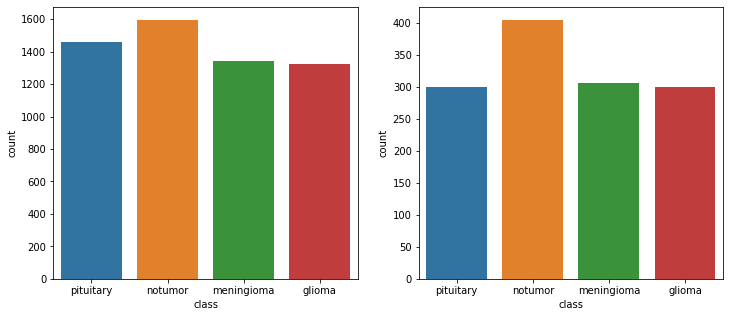

In [5]:
root_path = '../input/brain-tumor-mri-dataset'
labels = []
trainFolder = root_path+'/Training/'
testFolder = root_path+'/Testing/'

quantity_tr = {} 
quantity_te = {}
for folder in os.listdir(trainFolder):
    quantity_tr[folder] = len(os.listdir(trainFolder+folder))
    labels.append(folder)
    
for folder in os.listdir(testFolder):
    quantity_te[folder] = len(os.listdir(testFolder+folder))
    
    
quantity_train = pd.DataFrame(list(quantity_tr.items()),
                              index=range(0,len(quantity_tr)), columns=['class','count'])

quantity_test = pd.DataFrame(list(quantity_te.items()),
                              index=range(0,len(quantity_te)), columns=['class','count'])

figure, ax = plt.subplots(1,2,figsize=(12,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])

print("Number of images in training: ", sum(quantity_tr.values()))
print("Number of images in testing: ", sum(quantity_te.values()))

plt.show()

# Preprocessing

In [6]:
img_height = img_width = 150
batch_size = 32

In [7]:
labels

['pituitary', 'notumor', 'meningioma', 'glioma']

In [8]:
# reading the dataset
X_train = []
y_train = []

X_test = []
y_test = []

for i in labels:
    folderPath = os.path.join(root_path,'Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j), 1)
        img = cv2.resize(img,(img_height, img_width))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join(root_path,'Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j), 1)
        img = cv2.resize(img,(img_height, img_width))
        X_test.append(img)
        y_test.append(i)

100%|██████████| 300/300 [00:02<00:00, 118.80it/s]


In [9]:
# python list to numpy array
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [10]:
print(np.min(X_train), np.max(X_train))

0 255


In [11]:
# rescaling
X_train=X_train/255.0
X_test=X_test/255.0

In [12]:
print(np.min(X_train), np.max(X_train))

0.0 1.0


In [13]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5712, 150, 150, 3) (5712,)
(1311, 150, 150, 3) (1311,)


In [14]:
# Let's shuffle the data
X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)

In [15]:
# # One Hot Encoding
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)
# print(y_train)
# y_train = to_categorical(y_train)
# print(y_train)


# y_test = le.fit_transform(y_test)
# y_test = to_categorical(y_test)


In [16]:
# One Hot Encoding
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [17]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5712, 150, 150, 3) (5712, 4)
(1311, 150, 150, 3) (1311, 4)


In [18]:
train_datagen = ImageDataGenerator(        
        fill_mode="nearest",
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.1
)
test_datagen = ImageDataGenerator()


train_ds = train_datagen.flow(
  X_train, y_train,
  subset="training",
  shuffle=True,
  batch_size=batch_size)


In [19]:
val_ds = train_datagen.flow(
  X_train, y_train,
  subset="validation",
  shuffle=True,
  batch_size=batch_size)


In [20]:
test_ds = test_datagen.flow(
  X_test, y_test,
  shuffle=False,
  batch_size=batch_size)


In [21]:
j = 0
class_mapping = {}
for i in labels:
    class_mapping[j] = i
    j+=1
    
class_mapping

{0: 'pituitary', 1: 'notumor', 2: 'meningioma', 3: 'glioma'}

In [22]:
def show_few_images(number_of_examples=2, predict_using_model=None):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(testFolder)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(testFolder)):
        image_ids = os.listdir(os.path.join(testFolder,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            
            display = cv2.imread(os.path.join(testFolder,folder,image_ids[j]),1)
            display = cv2.resize(display, (img_height, img_width))/255.0
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True: '+folder
            if(predict_using_model):
                result = predict_using_model.predict(np.array([display]))
                #print(result)
                acc = str(round(np.max(result)*100, 3))
                predicted_classname = class_mapping[np.argmax(result)]
                title = title+'\nPrediction : '+predicted_classname+" - "+acc+"%"
            ax1[axs].set_title(title)
            axs=axs+1


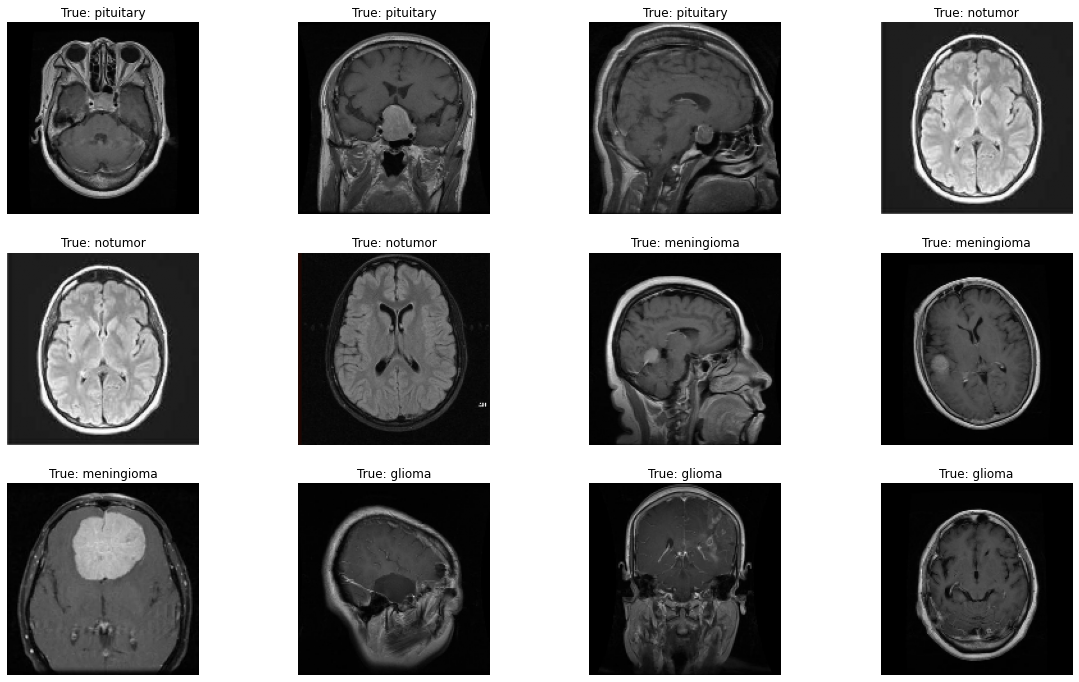

In [23]:
show_few_images(3)

In [24]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break


(32, 150, 150, 3)
(32, 4)


In [25]:
tf.keras.backend.clear_session()

# epoch config
epoch = 60

# Sequential Model

In [26]:
sequential_model = Sequential(
    [
        layers.Conv2D(32, (3, 3), input_shape=(img_height, img_width, 3), activation="relu", name="Conv1"),
        layers.MaxPooling2D(pool_size=(2, 2), name="Max_Pool_1"),
        
        layers.Conv2D(32, (3, 3), activation="relu", name="Conv2"),
        layers.MaxPooling2D(pool_size=(2, 2), name="Max_Pool_2"),
        
        layers.Conv2D(64, (3, 3), activation="relu", name="Conv3"),
        layers.MaxPooling2D(pool_size=(2, 2), name="Max_Pool_3"),
        
        layers.Flatten(),
        layers.Dense(256, activation="relu", name="fc1"),
        layers.Dropout(0.5),
        layers.Dense(4, activation="softmax", name="fc2"),    
    ]
)
sequential_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
sequential_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 148, 148, 32)      896       
_________________________________________________________________
Max_Pool_1 (MaxPooling2D)    (None, 74, 74, 32)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 72, 72, 32)        9248      
_________________________________________________________________
Max_Pool_2 (MaxPooling2D)    (None, 36, 36, 32)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 34, 34, 64)        18496     
_________________________________________________________________
Max_Pool_3 (MaxPooling2D)    (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [27]:
# tf.keras.utils.plot_model(sequential_model, show_shapes=True,
#                           to_file='img\cnnModel.jpg',
#                           dpi=1000,
#                          )

In [28]:
checkpoint_path = "model/model.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)


callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                       verbose=1,
                                       save_best_only=True,
                                       monitor = 'val_loss',
                                       mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.3,
                                        patience=2,
                                        verbose=1,
                                        mode='auto',
                                        min_delta=0.0001),
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    CSVLogger("myModel/mycnn_kaggle.log", separator=',', append=False),
]

I can save the best model using ModelCheckpoint callback. Thus I can run once and compile multiple times whereever I want. The CSVLogger logs the progressing epochs. I have displayed it in the 'Training and Validation Accuracy and Loss graph' in the below.

In [29]:
history = sequential_model.fit(train_ds,
                               epochs=epoch, 
                               verbose=1, 
                               validation_data = val_ds,
                               callbacks=callbacks)

Epoch 1/60
161/161 [==============================] - 33s 163ms/step - loss: 0.9190 - acc: 0.6034 - val_loss: 0.6578 - val_acc: 0.7320

Epoch 00001: val_loss improved from inf to 0.65776, saving model to myModel/mycnn_kaggle.hdf5
Epoch 2/60
161/161 [==============================] - 27s 165ms/step - loss: 0.6112 - acc: 0.7578 - val_loss: 0.5607 - val_acc: 0.7986

Epoch 00002: val_loss improved from 0.65776 to 0.56069, saving model to myModel/mycnn_kaggle.hdf5
Epoch 3/60
161/161 [==============================] - 26s 161ms/step - loss: 0.4691 - acc: 0.8135 - val_loss: 0.4461 - val_acc: 0.8459

Epoch 00003: val_loss improved from 0.56069 to 0.44612, saving model to myModel/mycnn_kaggle.hdf5
Epoch 4/60
161/161 [==============================] - 26s 164ms/step - loss: 0.4150 - acc: 0.8444 - val_loss: 0.4033 - val_acc: 0.8546

Epoch 00004: val_loss improved from 0.44612 to 0.40332, saving model to myModel/mycnn_kaggle.hdf5
Epoch 5/60
161/161 [==============================] - 26s 163ms/step

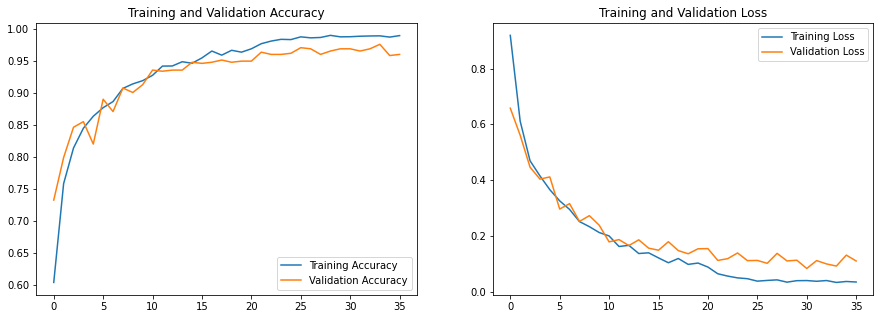

In [30]:
############ load trained model ################
sequential_model = keras.models.load_model("./myModel/mycnn_kaggle.hdf5", compile=False)

history = pd.read_csv("./myModel/mycnn_kaggle.log", sep=',', engine='python')

############### ########## ####### #######

acc=history['acc']
val_acc=history['val_acc']


loss = history['loss']
val_loss = history['val_loss']


epochs_range=range(len(acc))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
# plt.savefig("img/lossAndAccuracy_cnn.jpg", dpi=1000, bbox_inches='tight')

In [31]:
sequential_model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy'] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
test_loss, test_acc = sequential_model.evaluate(test_ds, batch_size=32, callbacks= callbacks)
print("test loss: %.2f, test acc: %.2f"%(test_loss, test_acc))

Evaluate on test data
41/41 [==============================] - 1s 10ms/step - loss: 0.0788 - accuracy: 0.9748
test loss: 0.08, test acc: 0.97


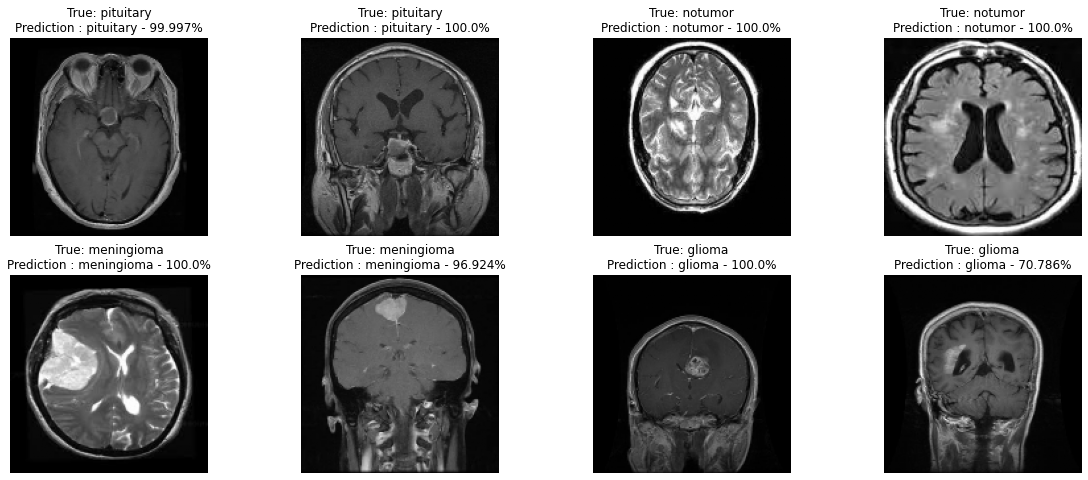

In [32]:
show_few_images(2, sequential_model)
# plt.savefig("img/trueVSpread_cnn.jpg", dpi=1000, bbox_inches='tight')

# VGG16 Model

In [33]:
# https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/
def create_model(input_shape=(img_height, img_width, 3), n_classes = len(labels), optimizer='adam', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.

    conv_base = VGG16(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)
   
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(256, activation='relu')(top_model)
    top_model = Dropout(0.5)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    
    return model
vgg16_final_model = create_model(fine_tune=0)
vgg16_final_model.summary()

58900480/58889256 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [34]:
# tf.keras.utils.plot_model(vgg16_final_model, show_shapes=True,
#                           to_file='img\vgg16Model.jpg',
#                           dpi=100,
#                          )

In [35]:
checkpoint_path = "myModel/myvgg16_kaggle.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                       verbose=1,
                                       save_best_only=True,
                                       monitor = 'val_loss',
                                       mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.3,
                                        patience=2,
                                        verbose=1,
                                        mode='auto',
                                        min_delta=0.0001),
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    CSVLogger("myModel/myvgg16_kaggle.log", separator=',', append=False)
]

In [36]:
# VGG16
vgg16_history = vgg16_final_model.fit(train_ds,
                                epochs = epoch,
                                validation_data = val_ds,
                                callbacks=callbacks,
                                verbose=1)

Epoch 1/60
161/161 [==============================] - 32s 187ms/step - loss: 0.7020 - acc: 0.7368 - val_loss: 0.4521 - val_acc: 0.8266

Epoch 00001: val_loss improved from inf to 0.45210, saving model to myModel/myvgg16_kaggle.hdf5
Epoch 2/60
161/161 [==============================] - 28s 173ms/step - loss: 0.4692 - acc: 0.8172 - val_loss: 0.3842 - val_acc: 0.8687

Epoch 00002: val_loss improved from 0.45210 to 0.38415, saving model to myModel/myvgg16_kaggle.hdf5
Epoch 3/60
161/161 [==============================] - 28s 174ms/step - loss: 0.4136 - acc: 0.8426 - val_loss: 0.3880 - val_acc: 0.8476

Epoch 00003: val_loss did not improve from 0.38415
Epoch 4/60
161/161 [==============================] - 28s 171ms/step - loss: 0.3889 - acc: 0.8559 - val_loss: 0.3518 - val_acc: 0.8634

Epoch 00004: val_loss improved from 0.38415 to 0.35185, saving model to myModel/myvgg16_kaggle.hdf5
Epoch 5/60
161/161 [==============================] - 28s 172ms/step - loss: 0.3658 - acc: 0.8592 - val_loss:

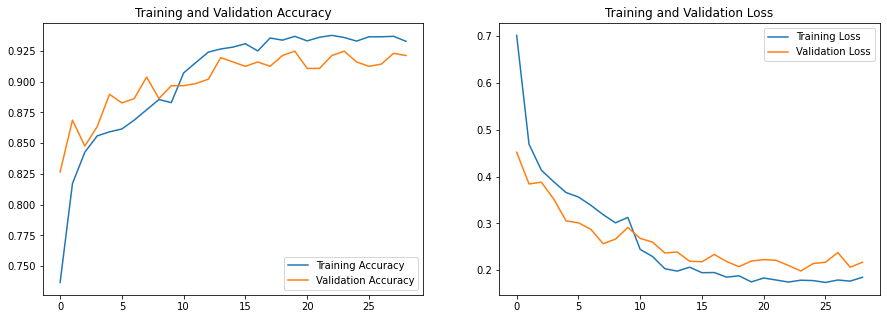

In [37]:
############ load trained model ################
vgg16_model = keras.models.load_model("./myModel/myvgg16_kaggle.hdf5", compile=False)

history = pd.read_csv("./myModel/myvgg16_kaggle.log", sep=',', engine='python')

############### ########## ####### #######

acc=history['acc']
val_acc=history['val_acc']


loss = history['loss']
val_loss = history['val_loss']


epochs_range=range(len(acc))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
# plt.savefig("img/lossAndAccuracy_vgg16.jpg", dpi=1000, bbox_inches='tight')

In [38]:
history

,epoch,acc,loss,lr,val_acc,val_loss
0,0,0.736822,0.701997,1.000000e-03,0.826620,0.452103
1,1,0.817156,0.469175,1.000000e-03,0.868652,0.384151
2,2,0.842638,0.413619,1.000000e-03,0.847636,0.387994
3,3,0.855865,0.388853,1.000000e-03,0.863398,0.351849
4,4,0.859171,0.365809,1.000000e-03,0.889667,0.305278
5,5,0.861506,0.356245,1.000000e-03,0.882662,0.301117
6,6,0.868703,0.338678,1.000000e-03,0.886165,0.287241
7,7,0.877067,0.318586,1.000000e-03,0.903678,0.256357
8,8,0.885431,0.301004,1.000000e-03,0.886165,0.266108
9,9,0.882902,0.312562,1.000000e-03,0.896672,0.291158


In [39]:
vgg16_model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy'] )
test_loss, test_acc = vgg16_model.evaluate(test_ds, batch_size=32, callbacks= callbacks)

41/41 [==============================] - 3s 71ms/step - loss: 0.2437 - accuracy: 0.9092


In [40]:
print("Evaluate on test data")
print("test loss: %.2f, test acc: %.2f"%(test_loss, test_acc))

Evaluate on test data
test loss: 0.24, test acc: 0.91


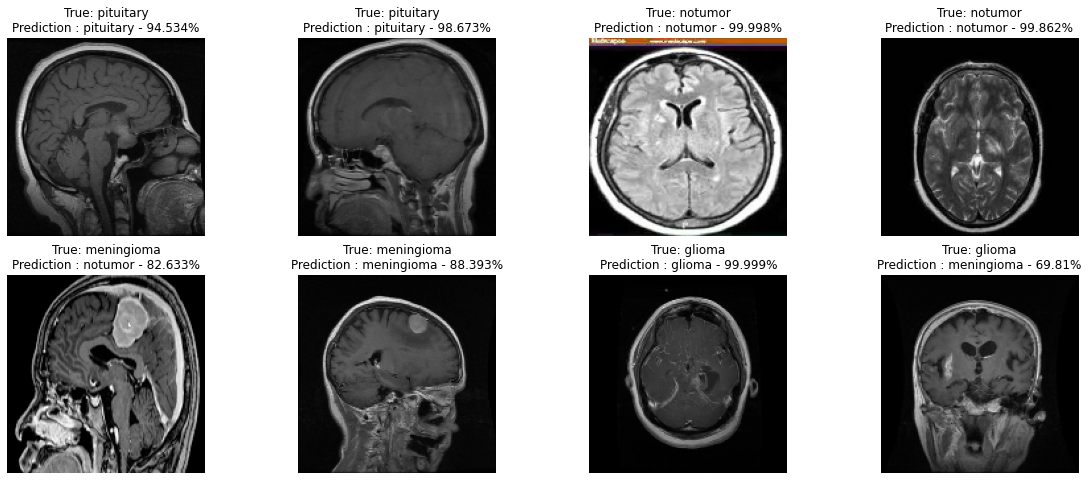

In [41]:
show_few_images(2, predict_using_model=vgg16_model)
# plt.savefig("img/trueVSpread_vgg16.jpg", dpi=1000, bbox_inches='tight')

# Performance Metrics

In [42]:
# https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    #print(cm)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr




def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a treshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list





def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")


## Sequential model

In [43]:
labels_pred= sequential_model.predict(test_ds)

In [44]:
y_pred = tf.argmax(labels_pred, axis=1)
# y_pred

In [45]:
y_true = tf.argmax(y_test, axis = 1)
# y_true

              precision    recall  f1-score   support

   pituitary       0.98      0.99      0.99       300
     notumor       0.98      0.99      0.99       405
  meningioma       0.94      0.97      0.95       306
      glioma       0.99      0.94      0.96       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.98      0.97      0.97      1311



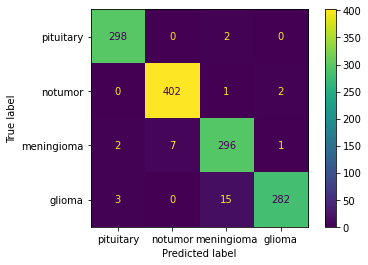

In [46]:
print(classification_report(y_true, y_pred, target_names=labels))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels)
plt.show()
# plt.savefig("img/confusionMatrix_cnn.jpg", dpi=1000, bbox_inches='tight')

In [47]:
# Calculating Sensitivity, Precision, and Specificity
cm = confusion_matrix(y_true, y_pred)
Sn_nt = round(cm[0,0] / (cm[0,0]+cm[0,1]+cm[0,2]+cm[0,3]),2)
Sn_m = round(cm[1,1] / (cm[1,1]+cm[1,0]+cm[1,2]+cm[1,3]),2) 
Sn_g = round(cm[2,2] / (cm[2,2]+cm[2,0]+cm[2,1]+cm[2,3]),2) 
Sn_p = round(cm[3,3] / (cm[3,3]+cm[3,0]+cm[3,1]+cm[3,2]),2) 


p_nt = round(cm[0,0] / (cm[0,0]+cm[1,0]+cm[2,0]+cm[3,0]),2)
p_m = round(cm[1,1] / (cm[1,1]+cm[0,1]+cm[2,1]+cm[3,1]),2) 
p_g = round(cm[2,2] / (cm[2,2]+cm[0,2]+cm[1,2]+cm[3,2]),2) 
p_p = round(cm[3,3] / (cm[3,3]+cm[0,3]+cm[1,3]+cm[2,3]),2)


Sp_nt = round((cm[1,1]+cm[2,2]+cm[3,3]) / (cm[1,1]+cm[2,2]+cm[3,3]+ cm[0,1]+ cm[0,2] +cm[0,3]),3)
Sp_m = round((cm[0,0]+cm[2,2]+cm[3,3]) / (cm[0,0]+cm[2,2]+cm[3,3]+ cm[1,0]+ cm[1,2] +cm[1,3]),3) 
Sp_g = round((cm[0,0]+cm[1,1]+cm[3,3]) / (cm[0,0]+cm[1,1]+cm[3,3]+ cm[2,0]+ cm[2,1] +cm[2,3]),3) 
Sp_p = round((cm[0,0]+cm[1,1]+cm[2,2]) / (cm[0,0]+cm[1,1]+cm[2,2]+ cm[3,0]+ cm[3,1] +cm[3,2]),3)


df = pd.DataFrame([["Sensitivity",Sn_nt,Sn_m,Sn_g,Sn_p],
                   ["Precision",p_nt,p_m,p_g,p_p],
                   ["Specificity",Sp_nt,Sp_m,Sp_g,Sp_p]],
                  columns=["Metrics","No Tumor","Meningioma","Glioma","Pituitary"])
df.head()

,Metrics,No Tumor,Meningioma,Glioma,Pituitary
0,Sensitivity,0.990,0.990,0.97,0.940
1,Precision,0.980,0.980,0.94,0.990
2,Specificity,0.998,0.997,0.99,0.982


****Note: As you can see I have created the above dataframe manualy, and there are some drawbacks. When I did coding in my local machine, the labeling appeared in a sequence such as: No tumor, Meningioma, Glioma and lastly Pituitary, and I wrote as required. You are advised to create your own.****

In [48]:
# Cohen Kappa Score
print("Cohen Kappa Score: %.3f"%cohen_kappa_score(y_true, y_pred))

# Matthew’s correlation coefficient
print("Matthew’s correlation coefficient: %.3f"%matthews_corrcoef(y_true, y_pred))


Cohen Kappa Score: 0.966
Matthew’s correlation coefficient: 0.966


### ROC Curve - One vs Rest (OvR)

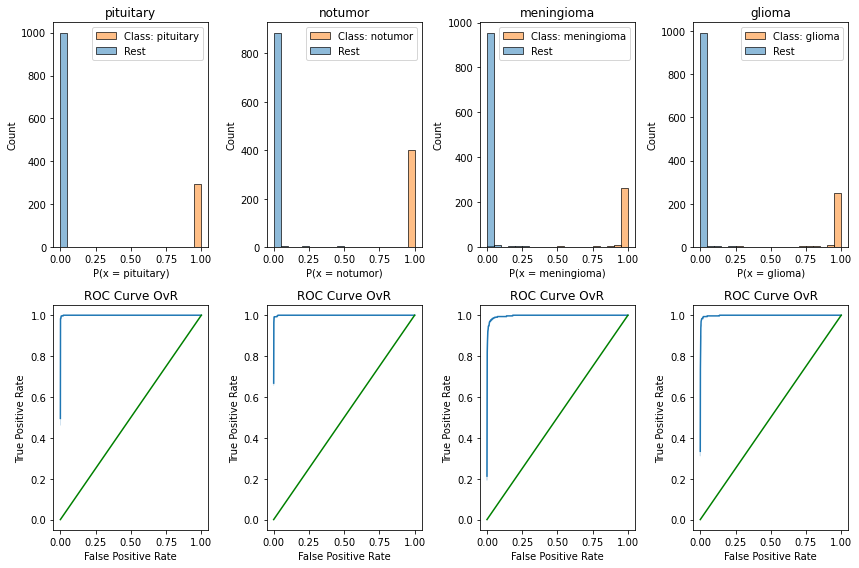

In [49]:
# Plots the Probability Distributions and the ROC Curves One vs Rest
plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovr = {}

my_labels = [i for i in range(len(labels))]
df_aux = pd.DataFrame()

for i in range(len(my_labels)):
    # Gets the class
    c = my_labels[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux['class'] = [1 if y == c else 0 for y in y_true]    
    df_aux['prob'] = labels_pred[:, i]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 4, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(class_mapping[c])
    ax.legend([f"Class: {class_mapping[c]}", "Rest"])
    ax.set_xlabel(f"P(x = {class_mapping[c]})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 4, i+5)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
    
plt.tight_layout()
# plt.savefig("img/ROC_AUC_OvR_CNN.jpg", dpi=1000, bbox_inches='tight')



If the histograms overlap, then the model is struggling to classify that particular class. The more separate the histograms are, the better the ROC Curves are as well. From above, we can see that our CNN model is performing very well in classifying No Tumor and Pituitary Tumor.

In [50]:
# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovr:
    avg_roc_auc += roc_auc_ovr[k]
    i += 1
    print(f"Class {class_mapping[k]}: ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
print(f"Average ROC AUC OvR: {avg_roc_auc/i:.4f}")

Class pituitary: ROC AUC OvR: 0.9999
Class notumor: ROC AUC OvR: 0.9997
Class meningioma: ROC AUC OvR: 0.9966
Class glioma: ROC AUC OvR: 0.9984
Average ROC AUC OvR: 0.9987


## VGG16 Model

In [51]:
labels_pred= vgg16_model.predict(test_ds)

In [52]:
y_pred = tf.argmax(labels_pred, axis=1)
# y_pred

In [53]:
y_true = tf.argmax(y_test, axis = 1)
# y_true

              precision    recall  f1-score   support

   pituitary       0.89      0.99      0.94       300
     notumor       0.95      0.99      0.97       405
  meningioma       0.82      0.86      0.84       306
      glioma       0.98      0.77      0.86       300

    accuracy                           0.91      1311
   macro avg       0.91      0.90      0.90      1311
weighted avg       0.91      0.91      0.91      1311



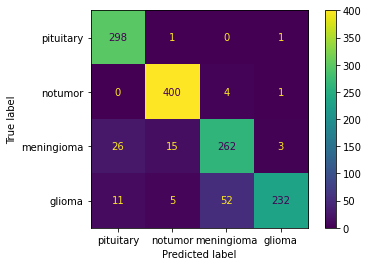

In [54]:
print(classification_report(y_true, y_pred, target_names=labels))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels)
plt.show()
# plt.savefig("img/confusionMatrix_cnnvgg16.jpg", dpi=1000, bbox_inches='tight')

In [55]:
# Calculating Sensitivity, Precision, and Specificity
cm = confusion_matrix(y_true, y_pred)
Sn_nt = round(cm[0,0] / (cm[0,0]+cm[0,1]+cm[0,2]+cm[0,3]),2)
Sn_m = round(cm[1,1] / (cm[1,1]+cm[1,0]+cm[1,2]+cm[1,3]),2) 
Sn_g = round(cm[2,2] / (cm[2,2]+cm[2,0]+cm[2,1]+cm[2,3]),2) 
Sn_p = round(cm[3,3] / (cm[3,3]+cm[3,0]+cm[3,1]+cm[3,2]),2) 


p_nt = round(cm[0,0] / (cm[0,0]+cm[1,0]+cm[2,0]+cm[3,0]),2)
p_m = round(cm[1,1] / (cm[1,1]+cm[0,1]+cm[2,1]+cm[3,1]),2) 
p_g = round(cm[2,2] / (cm[2,2]+cm[0,2]+cm[1,2]+cm[3,2]),2) 
p_p = round(cm[3,3] / (cm[3,3]+cm[0,3]+cm[1,3]+cm[2,3]),2)


Sp_nt = round((cm[1,1]+cm[2,2]+cm[3,3]) / (cm[1,1]+cm[2,2]+cm[3,3]+ cm[0,1]+ cm[0,2] +cm[0,3]),3)
Sp_m = round((cm[0,0]+cm[2,2]+cm[3,3]) / (cm[0,0]+cm[2,2]+cm[3,3]+ cm[1,0]+ cm[1,2] +cm[1,3]),3) 
Sp_g = round((cm[0,0]+cm[1,1]+cm[3,3]) / (cm[0,0]+cm[1,1]+cm[3,3]+ cm[2,0]+ cm[2,1] +cm[2,3]),3) 
Sp_p = round((cm[0,0]+cm[1,1]+cm[2,2]) / (cm[0,0]+cm[1,1]+cm[2,2]+ cm[3,0]+ cm[3,1] +cm[3,2]),3)


df = pd.DataFrame([["Sensitivity",Sn_nt,Sn_m,Sn_g,Sn_p],
                   ["Precision",p_nt,p_m,p_g,p_p],
                   ["Specificity",Sp_nt,Sp_m,Sp_g,Sp_p]],
                  columns=["Metrics","No Tumor","Meningioma","Glioma","Pituitary"])
df.head()

,Metrics,No Tumor,Meningioma,Glioma,Pituitary
0,Sensitivity,0.990,0.990,0.860,0.770
1,Precision,0.890,0.950,0.820,0.980
2,Specificity,0.998,0.994,0.955,0.934


**Note: As you can see I have created the above dataframe manualy, and there are some drawbacks. When I did coding in my local machine, the labeling appeared in a sequence such as: No tumor, Meningioma, Glioma and lastly Pituitary, and I wrote as required. You are advised to create your own.**

In [56]:
# Cohen Kappa Score
print("Cohen Kappa Score: %.3f"%cohen_kappa_score(y_true, y_pred))

# Matthew’s correlation coefficient
print("Matthew’s correlation coefficient: %.3f"%matthews_corrcoef(y_true, y_pred))


Cohen Kappa Score: 0.878
Matthew’s correlation coefficient: 0.880


### ROC Curve - One vs Rest (OvR)

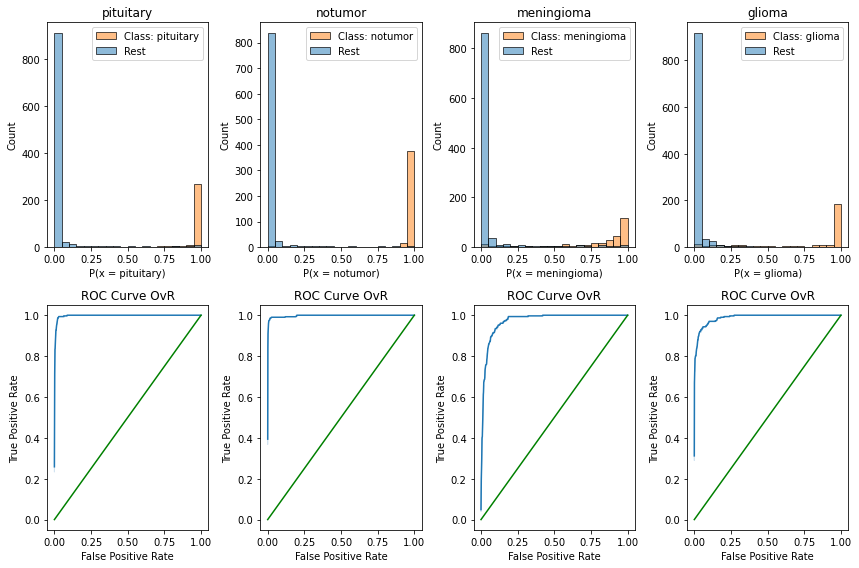

In [57]:
# Plots the Probability Distributions and the ROC Curves One vs Rest
plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovr = {}

my_labels = [i for i in range(len(labels))]
df_aux = pd.DataFrame()

for i in range(len(my_labels)):
    # Gets the class
    c = my_labels[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux['class'] = [1 if y == c else 0 for y in y_true]    
    df_aux['prob'] = labels_pred[:, i]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 4, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(class_mapping[c])
    ax.legend([f"Class: {class_mapping[c]}", "Rest"])
    ax.set_xlabel(f"P(x = {class_mapping[c]})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 4, i+5)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
    
plt.tight_layout()
# plt.savefig("img/ROC_AUC_OvR_VGG16.jpg", dpi=1000, bbox_inches='tight')


In [58]:
# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovr:
    avg_roc_auc += roc_auc_ovr[k]
    i += 1
    print(f"Class {class_mapping[k]}: ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
print(f"Average ROC AUC OvR: {avg_roc_auc/i:.4f}")


Class pituitary: ROC AUC OvR: 0.9971
Class notumor: ROC AUC OvR: 0.9976
Class meningioma: ROC AUC OvR: 0.9719
Class glioma: ROC AUC OvR: 0.9879
Average ROC AUC OvR: 0.9886


# Investigating feature map 

## CNN(Sequential Model)

In [59]:
i=0
for layers in sequential_model.layers:
    print(i, layers)
    i+=1

0 <keras.layers.convolutional.Conv2D object at 0x7fcb701e25d0>
1 <keras.layers.pooling.MaxPooling2D object at 0x7fcb0c350bd0>
2 <keras.layers.convolutional.Conv2D object at 0x7fcb729c4a50>
3 <keras.layers.pooling.MaxPooling2D object at 0x7fcb0c319c10>
4 <keras.layers.convolutional.Conv2D object at 0x7fcb0c314f10>
5 <keras.layers.pooling.MaxPooling2D object at 0x7fcb0c32d9d0>
6 <keras.layers.core.Flatten object at 0x7fcb0c32a3d0>
7 <keras.layers.core.Dense object at 0x7fcb700ff350>
8 <keras.layers.core.Dropout object at 0x7fcb701b9090>
9 <keras.layers.core.Dense object at 0x7fcb0c2c4a50>


There are 10 layers in our sequential model.</br>
1,3,5 are Convolutional layers.</br>
2,4,6 are Pooling layers</br>
7 is the Flatten layer<br>
8,10 are Fully connected Dense layers</br>
9 is the Droupout layer

In [60]:
img_path = root_path+"/Testing/meningioma/Te-meTr_0004.jpg"
display = cv2.imread(img_path,1)
display = cv2.resize(display, (img_height, img_width))/255.0

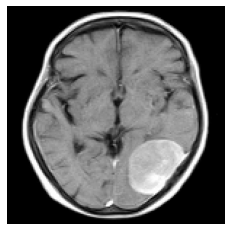

In [61]:
plt.axis('off')
plt.imshow(display)
plt.show()

In [62]:
result = sequential_model.predict(np.array([display]))
predicted_classname = class_mapping[np.argmax(result)]

In [63]:
prob = round(np.max(result)*100, 3)
print("Prediction: ",predicted_classname, "\nProbability: ",prob,"%")

Prediction:  meningioma 
Probability:  99.552 %


In [64]:
result2 = vgg16_model.predict(np.array([display]))
predicted_classname = class_mapping[np.argmax(result)]

In [65]:
prob = round(np.max(result2)*100, 3)
print("Prediction: ",predicted_classname, "\nProbability: ",prob,"%")

Prediction:  meningioma 
Probability:  95.091 %


In [66]:
# feature_maps

In [67]:
ids = [0,2,4]
model = Model(inputs=sequential_model.inputs, outputs = [sequential_model.layers[i].output for i in ids])

In [68]:
feature_maps = model.predict(np.array([display]))

Output of Convolution 1 , Shape of feature map [samples, rows, cols, channels]:  (1, 148, 148, 32)


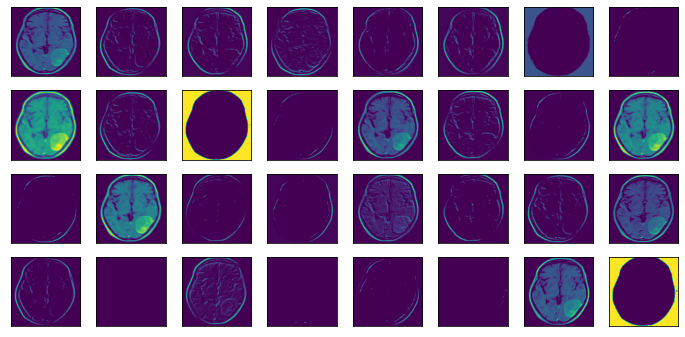

Output of Convolution 3 , Shape of feature map [samples, rows, cols, channels]:  (1, 72, 72, 32)


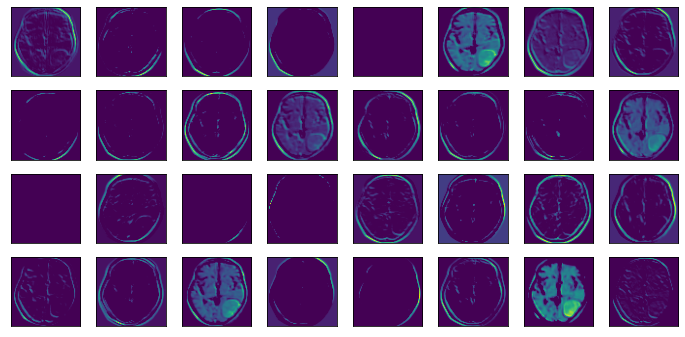

Output of Convolution 5 , Shape of feature map [samples, rows, cols, channels]:  (1, 34, 34, 64)


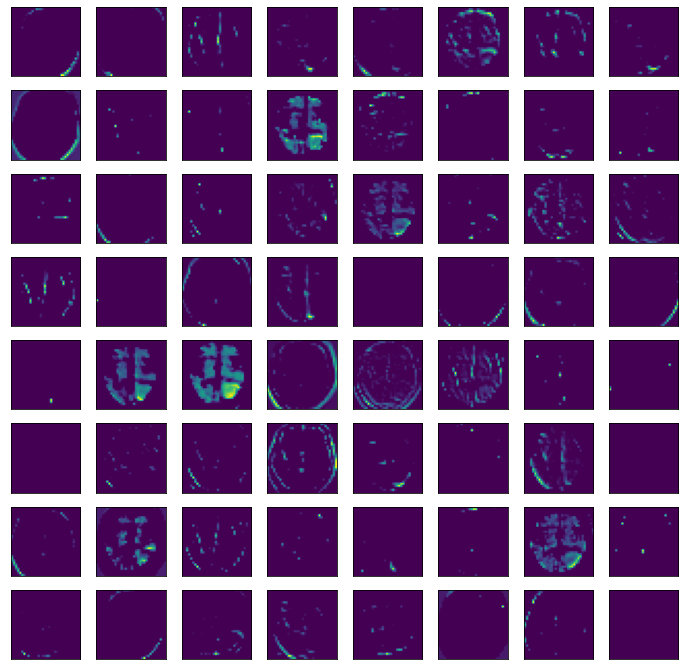

In [69]:
sq1=8
sq2=4
i=1
for fmap in feature_maps:
    plt.figure(figsize=(12, 12))
    print("Output of Convolution",i,", Shape of feature map [samples, rows, cols, channels]: ",fmap.shape)
    i+=2
    ix=1
    if fmap.shape[3]==64:
        sq2=8
    for _ in range(sq1):
        for _ in range(sq2):
            ax = plt.subplot(8,8,ix)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(fmap[0,:,:,ix-1])
            ix+=1
            
    plt.show()

##  VGG16

In [70]:
i=0
for layers in vgg16_model.layers:
    print(i, layers)
    i+=1

0 <keras.engine.input_layer.InputLayer object at 0x7fcaebf4b290>
1 <keras.layers.convolutional.Conv2D object at 0x7fcaebf4b750>
2 <keras.layers.convolutional.Conv2D object at 0x7fcaebf4b450>
3 <keras.layers.pooling.MaxPooling2D object at 0x7fcb7277b750>
4 <keras.layers.convolutional.Conv2D object at 0x7fcb729045d0>
5 <keras.layers.convolutional.Conv2D object at 0x7fcaebf42550>
6 <keras.layers.pooling.MaxPooling2D object at 0x7fcaebf4b250>
7 <keras.layers.convolutional.Conv2D object at 0x7fcaebf521d0>
8 <keras.layers.convolutional.Conv2D object at 0x7fcaebf52650>
9 <keras.layers.convolutional.Conv2D object at 0x7fcaebf52d10>
10 <keras.layers.pooling.MaxPooling2D object at 0x7fcaebf57410>
11 <keras.layers.convolutional.Conv2D object at 0x7fcaebf577d0>
12 <keras.layers.convolutional.Conv2D object at 0x7fcaebf57c10>
13 <keras.layers.convolutional.Conv2D object at 0x7fcaebf592d0>
14 <keras.layers.pooling.MaxPooling2D object at 0x7fcaebf59990>
15 <keras.layers.convolutional.Conv2D object at 

In [71]:
# Only the last Convolutional layer
vggmodel = Model(inputs=vgg16_model.inputs, outputs = [vgg16_model.layers[17].output])

In [72]:
feature_maps = vggmodel.predict(np.array([display]))

In [73]:
feature_maps.shape

(1, 9, 9, 512)

Output of last Convolution, Shape of feature map [samples, rows, cols, channels]:  (1, 9, 9, 512)
Showing 1 - 512 channels


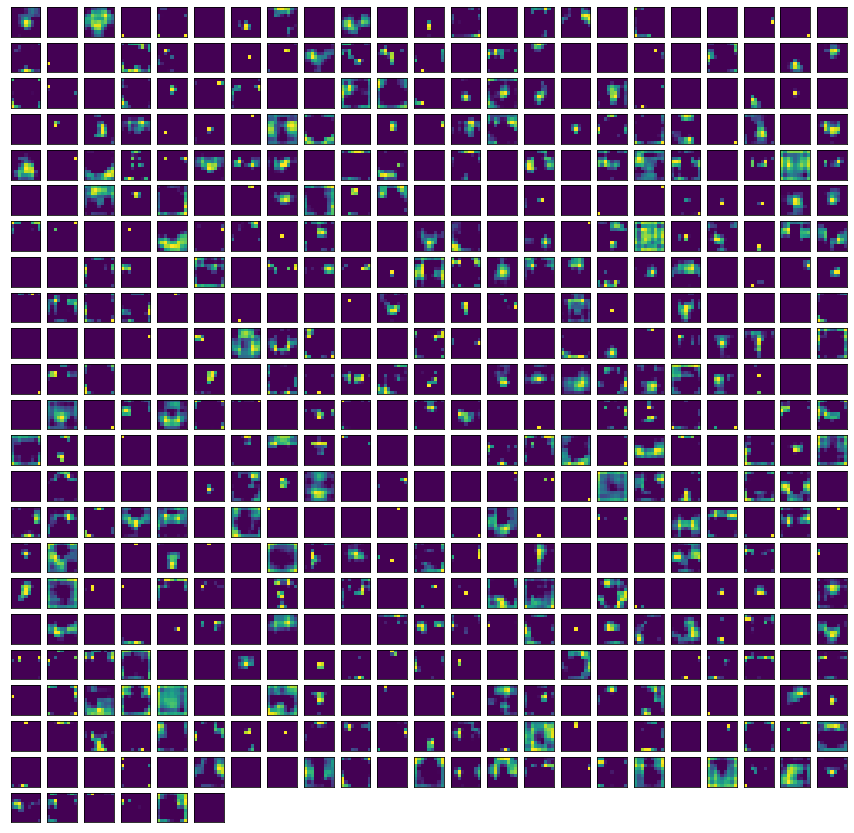

In [74]:
sq1=23
sq2=23
plt.figure(figsize=(15, 15))
print("Output of last Convolution, Shape of feature map [samples, rows, cols, channels]: ",feature_maps.shape)
ix=1

for _ in range(sq1):
    for _ in range(sq2):
        ax = plt.subplot(23,23,ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(feature_maps[0,:,:,ix-1])
        if ix==512:
            break
        ix+=1
print("Showing 1 -",ix, "channels")
plt.show()

Please upvote and share your thoughts. Find me on [github](https://github.com/AsadullahGalib007).